# Text To Emotion

### Bài toán
- Phân loại văn bản theo 4 loại cảm xúc cơ bản (neutral, happy, angry, sad).

### Mục tiêu
- Tìm hiểu được cách crawl văn bản từ Google API.
- Tìm hiểu được cách preprocessing văn bản.
- Tìm hiểu được các cách biến đổi từ văn bản thành vector.
- Tìm hiểu được và xây dựng một nền tảng để có thể phân loại được cảm xúc khi nhập vào một đoạn văn bản.
- Tìm hiểu thêm được framework keras cũng như các hướng tiếp cận khác của bài toán.

### Ứng dụng
- Hiểu được cảm xúc của người dùng thông qua các dòng bình luận, nhận xét, đánh giá.
- Từ đó, có thể ứng dụng vào phân loại các cảm xúc của các comment từ đó rút ra thống kê, có thể ứng dụng vào trong các ứng dụng như: phân loại comment đánh giá sản phẩm (e-commerce), phân loại comment đánh giá trên facebook post, xếp loại video youtube bằng cách phân loại comment.
- Ứng dụng để gợi ý emoji trong các loại ứng dụng chat.

### Crawl dữ liệu
#### API
- Sử dụng GoogleAPIs crawl comment từ các video youtube, mỗi url video đa số chứa những comment thuộc cùng một nhóm. Ví dụ: video về nền công nghiệp gà, bò, hay chiến tranh thì đa số là angry, cũng có sad, các video âm nhạc giải trí mang tính thư giãn thì happy, những video của các vlogger thì đa phần là hỗn tạp vì có người thích và có người ghét.
    1. WjNFGZLJLss (angry)
    2. 5xzGjW_MEms (sad)
    3. nKDgFCojiT8 (sad)
    4. hEH7KgQY380 (happy)
    5. kIF3BYBXZWA (happy)
    6. NvZtkt9973A (happy)
    7. SuYwm-wBwBY (happy)
    8. iqmO1RlqorU (happy)
    9. 9ca8ThA83fE (happy)
    10. V-RwqjtQmm8 (angry)
    11. WuLZ9ZMA_FA (angry)
    12. kopI4-ebPxQ (prank)
    13. LEBtUTAf8uE (prank)
    14. eBSr1oiIDuU (prank)
    15. UYJl7z38V88 (prank)

#### Thông tin dữ liệu crawl
- Dữ liệu ở đây lên đến ~35k comment.
- Thông tin dữ liệu crawl chỉ là những comment, reply, không có label.
- Dẫn đến việc nhóm phải tự annotation lại dữ liệu bằng tay.

#### Annotation
- Nhóm có tự tạo file annotation.py để hỗ trợ việc annotate nhanh hơn và lưu lại cache để ghi nhớ những comment chưa annotate.
- Dữ liệu sau khi nhóm tự annotate vào khoảng ~12k comment.
- Các file dữ liệu dùng để anotate bao gồm:
    - encoded_angry.txt
    - encoded_happy.txt
    - encoded_sad.txt
    - encoded_prank.txt
- Nhóm sử dụng file script anotate để tạo thuận tiện cho việc anotate hơn.
- Kết quả sau khi anotate là các file:
    - final_angry.csv
    - final_happy.csv
    - final_sad.csv
    - final_prank.csv
    
#### Resources
- Glove Vect: https://www.kaggle.com/watts2/glove6b50dtxt
- Stop words in Natural Language Toolkit: https://www.nltk.org/data.html 
- Crawl Data: https://youtube.com

In [30]:
from time import time
import string
import os
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

import codecs
import json
import re
import collections
import heapq
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

%matplotlib inline

In [2]:
f = codecs.open("./glove.6B.50d.txt","r","utf-8")
lines = f.readlines()
words = [x.split(' ')[0] for x in lines]
glove_dict = {}
for word in words:
    glove_dict[word] = word
f.close()
# Mở file đang làm dang dở trước đó (nếu có)
glove_dict.update(json.loads(open('dictionary.txt', "r").read()))

- Đầu tiên ta sẽ đọc data đã crawl từ 4 file *final_happy.csv*, *final_angry.csv*, *final_sad.csv*, *final_prank.csv*
- Vì đọc các file theo thứ tự nên data sẽ theo được sort theo trình tự happy -> angry -> sad -> prank. Nên ta sẽ shuffle lại data bằng hàm `df.reindex` kết hợp với `np.random.permutation`.
- Tiếp tục ta sẽ đổi header cho dễ đọc, dễ xử lý.

In [3]:
# Load các file csv vào thành 1 DataFrame
happy_train = pd.read_csv('./CrawlComment/final_happy.csv', sep='\t', header=None)
angry_train = pd.read_csv('./CrawlComment/final_angry.csv', sep='\t', header=None)
sad_train = pd.read_csv('./CrawlComment/final_sad.csv', sep='\t', header=None)
prank_train = pd.read_csv('./CrawlComment/final_prank.csv', sep='\t', header=None)
frames = [happy_train, angry_train, sad_train, prank_train]
df = pd.concat(frames, ignore_index=True)
df.info()

df = df.reindex(np.random.permutation(df.index))
df = df.rename(columns={0: "text", 1: "emotion"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 2 columns):
0    12864 non-null object
1    12864 non-null int64
dtypes: int64(1), object(1)
memory usage: 201.1+ KB


## 1. Observation and Preprocessing data

- Để biết được phân phối của dataset có đều nhau hay không hay nói cách khác là số lượng các emotion có đều nhau hay không, ta sẽ plot và sinh ra thêm một cột là emotion_label để visualize.
- Kết quả cho thấy Sad có số lượng lớn nhất, sau đó đến Neutral, Happy và cuối cùng là Angry.

| Emotion      | Emotion Label |
| :------------: | :-------------: |
| 0            | Neutral       |
| 1            | Happy         |
| 2            | Angry         |
| 3            | Sad           |

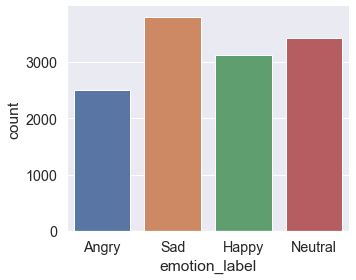

In [4]:
mapping = {
    3: 'Sad',
    0: 'Neutral',
    1: 'Happy',
    2: 'Angry'
}

def mappingToEmotion(value):
    return mapping[value]

df['emotion_label'] = df['emotion'].apply(mappingToEmotion) 
target_dist = sns.catplot(x="emotion_label", data=df, kind="count", height=4, aspect=1.2)
plt.show();

Ta xây dựng một lớp `Counting` để rút ra các features từ các sentences:
1. count_words: Số lượng từ trong một câu.
2. count_capital: Số lượng từ mà viết hoa trong một câu.
3. count_excl_quest: Số lượng dấu chấm hỏi và dấu chấm than.
4. count_positive_emojis: Số lượng emojis tích cực.
5. count_negative_emojis: Số lượng emojis tiêu cực.

In [5]:
class Counting(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, sentence):
        return len(re.findall(pattern, sentence))
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        count_words = X['text'].apply(lambda x: self.count_regex(r'\w+', x)) 
        count_capital = X['text'].apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest = X['text'].apply(lambda x: self.count_regex(r'!|\?', x))
        count_positive_emojis = X['text'].apply(lambda x: self.count_regex(r'[:=x][)D]', x))
        count_negative_emojis = X['text'].apply(lambda x: self.count_regex(r'[:]\'?[(]', x))
        
        df = X.copy()
        df['count_words'] = count_words
        df['count_capital'] = count_capital
        df['count_excl_quest'] = count_excl_quest
        df['count_positive_emojis'] = count_positive_emojis
        df['count_negative_emojis'] = count_negative_emojis
        
        return df

In [6]:
tc = Counting()
df_counts = tc.fit_transform(df)
df_counts['emotion_label'] = df['emotion_label']
df_counts['emotion'] = df['emotion']

In [7]:
def plt_hist(df, col, max_bin=None):
    if max_bin == None:
        max_bin = df[col].max() + 1
    print('Mô tả cho cột {}'.format(col))
    print()
    print(df.groupby('emotion_label')[col].describe())
    bins = np.arange(df[col].min(), max_bin)
    g = sns.FacetGrid(df, col='emotion_label', height=5, hue='emotion_label')
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Mô tả cho cột count_words

                count       mean        std  min  25%  50%   75%    max
emotion_label                                                          
Angry          2502.0  13.331735  17.268034  0.0  5.0  8.0  15.0  272.0
Happy          3128.0   9.584399  14.001390  0.0  3.0  6.0  11.0  372.0
Neutral        3436.0  10.584109  15.369232  0.0  5.0  8.0  12.0  501.0
Sad            3798.0  12.285677  16.344083  0.0  5.0  8.0  14.0  288.0


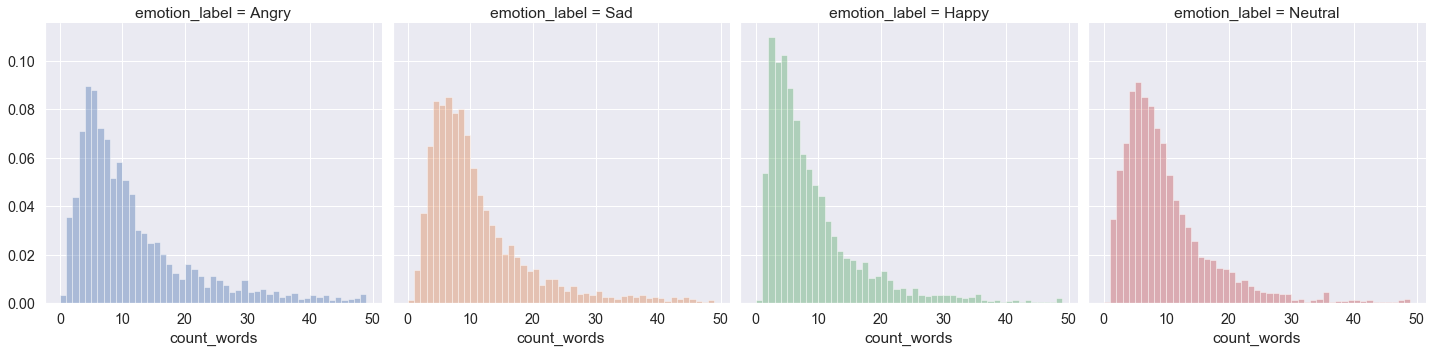

In [8]:
plt_hist(df_counts, col='count_words', max_bin=50)

Mô tả cho cột count_positive_emojis

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.003197  0.056467  0.0  0.0  0.0  0.0   1.0
Happy          3128.0  0.073210  0.351449  0.0  0.0  0.0  0.0  11.0
Neutral        3436.0  0.004366  0.065937  0.0  0.0  0.0  0.0   1.0
Sad            3798.0  0.003686  0.064809  0.0  0.0  0.0  0.0   2.0


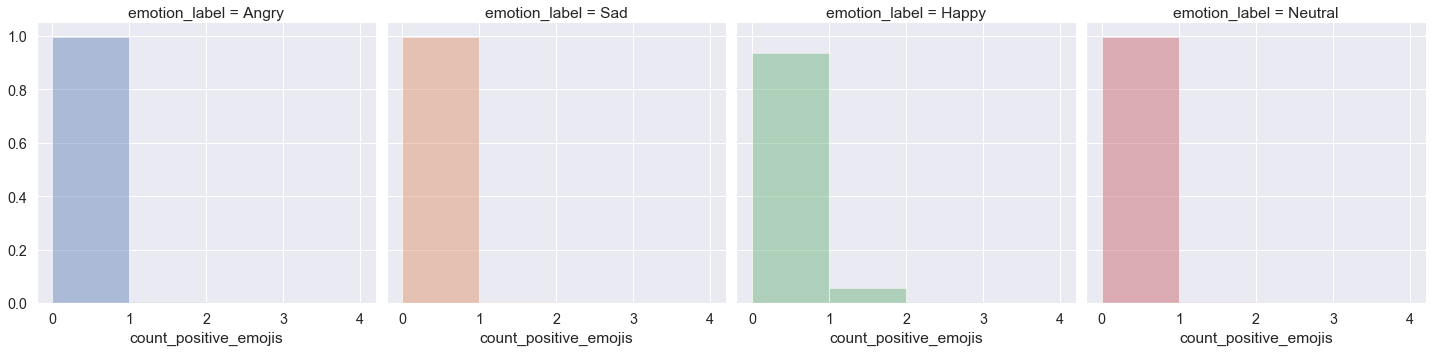

In [9]:
plt_hist(df_counts, col='count_positive_emojis', max_bin=5)

Mô tả cho cột count_negative_emojis

                count      mean       std  min  25%  50%  75%  max
emotion_label                                                     
Angry          2502.0  0.000799  0.028267  0.0  0.0  0.0  0.0  1.0
Happy          3128.0  0.000320  0.017880  0.0  0.0  0.0  0.0  1.0
Neutral        3436.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
Sad            3798.0  0.017378  0.138517  0.0  0.0  0.0  0.0  3.0


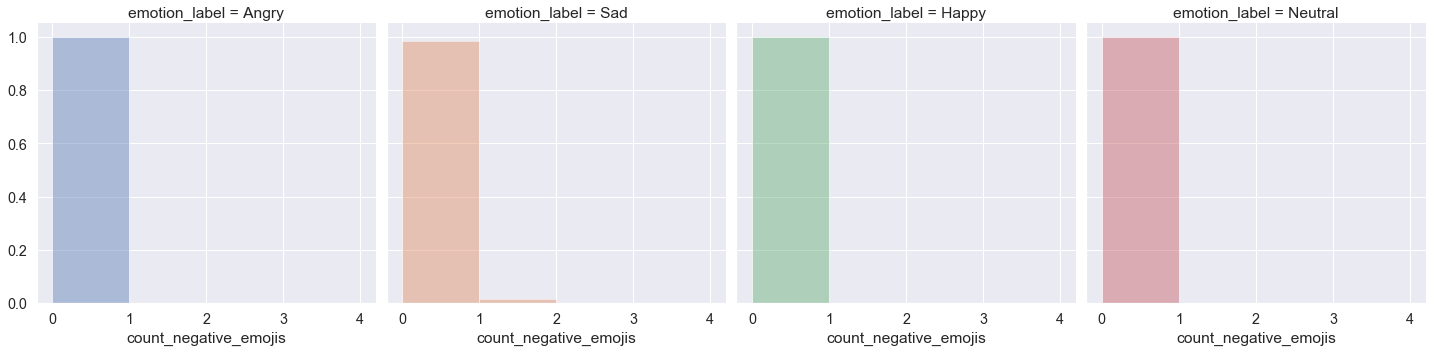

In [10]:
plt_hist(df_counts, col='count_negative_emojis', max_bin=5)

Mô tả cho cột count_excl_quest

                count      mean       std  min  25%  50%  75%   max
emotion_label                                                      
Angry          2502.0  0.578737  2.812265  0.0  0.0  0.0  0.0  82.0
Happy          3128.0  0.510230  1.992123  0.0  0.0  0.0  0.0  64.0
Neutral        3436.0  0.304715  0.913104  0.0  0.0  0.0  0.0  12.0
Sad            3798.0  0.291732  1.125840  0.0  0.0  0.0  0.0  36.0


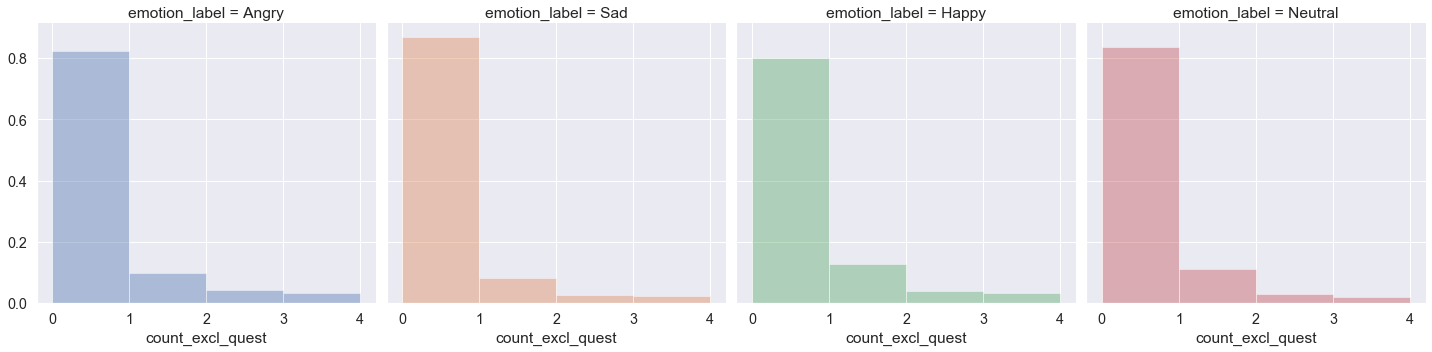

In [11]:
plt_hist(df_counts, col='count_excl_quest', max_bin=5)

Mô tả cho cột count_capital

                count      mean       std  min  25%  50%  75%    max
emotion_label                                                       
Angry          2502.0  0.757394  4.060800  0.0  0.0  0.0  0.0  110.0
Happy          3128.0  0.270460  1.530961  0.0  0.0  0.0  0.0   35.0
Neutral        3436.0  0.336438  1.645697  0.0  0.0  0.0  0.0   40.0
Sad            3798.0  0.406793  2.340993  0.0  0.0  0.0  0.0   97.0


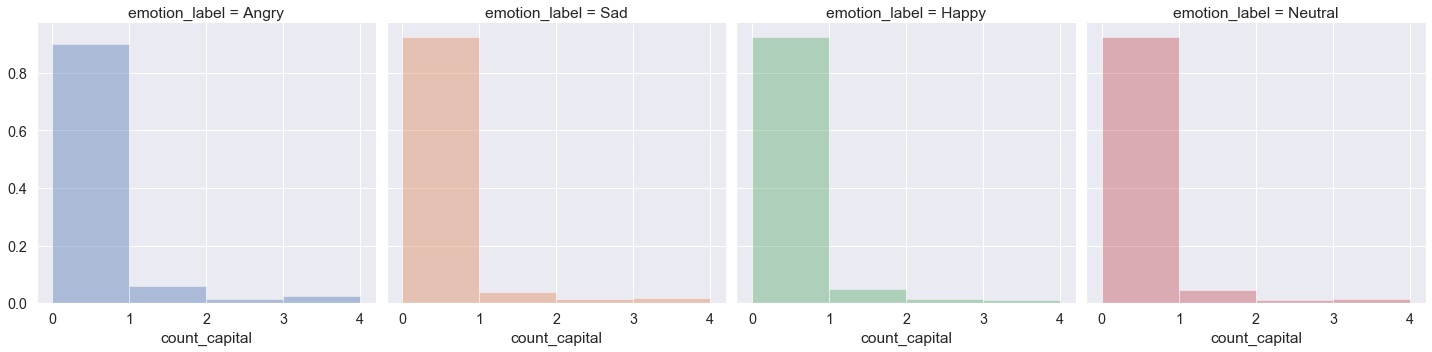

In [12]:
plt_hist(df_counts, col='count_capital', max_bin=5)

### Nhận xét
- `count_words`: Ta có thể thấy, những câu angry thường có số lượng từ nhiều hơn.
- `count_positive_emojis`: Đúng như nhóm dự đoán, những emoji tích cực sẽ tập trung ở label happy nhiều nhất, nhưng ở mỗi câu thì sẽ không chắc có emoji nên ở happy `mean` = 0.073
- `count_negative_emojis`: Tương tự như positive emojis, negative emoji sẽ tập trung ở sad nhiều nhất, `mean` = 0.017
- `count_excl_quest` và `count_capital`: Số lượng dấu chấm hỏi, dấu chấm than, và số lượng từ được in hoa sẽ xuất hiện nhiều nhất hơn emotion angry.

Nhóm sẽ quyết định giữ lại 5 thuộc tính này cho việc prediction.

### Clean the sentence

Sau khi có nhiều góc nhìn về dữ liệu và extract được 5 feature ở trên. Nhóm quyết định sử dụng tư tưởng Bag Of Word (BOW) để áp dụng vào field `text`. Nhưng với field `text` hiện tại có những bất cập:
   - Kí tự đặc biệt, số,...
   - Viết tắt: "omg", "asap", "tbh", ...
   - Viết sai chính tả
   - Viết nhảm (spam)
   - Có tên người
   - ...

Các bước chuẩn bị dữ liệu:
- Chuyển tất cả thành chữ thường
- Chỉ giữa các kí tự, xóa các kí tự đặc biệt và số, xóa các dòng text là rỗng
- Chuyển những từ sai chính tả thành những từ map với `glove_dict`, nếu từ đó không có trong `glove_dict`, nhóm sẽ nhập tay.
- Xóa tất cả các stop words dựa vào thư viện `nltk.corpus`.

In [13]:
class MakeCleanText(BaseEstimator, TransformerMixin):
    def normalize(self, x):
        try:
            x = x.lower().strip()
        except:
            return ''
        ans = ''
        for i in x:
            if 'a' <= i <= 'z' or i == ' ':
                ans += i
        return ans
    
    def keep_clean(self, sentence):
        sentence = sentence.strip()
        return ' '.join(sentence.split())
    
    def only_keep_alphabets(self, sentence):
        return self.normalize(sentence)
    
    def remove_spaces(self, sentence):
        return self.keep_clean(sentence)
    
    def translate_unknow_word(self, sentence):
        new_line = ''
        for word in sentence.split():
            if word not in glove_dict:
                print(word)
                glove_dict[word] = input(word + ' ')
                open("dictionary.txt", "w").write(json.dumps(glove_dict))
            else:
                new_line += ' ' + glove_dict[word]

        return new_line
    
    def remove_stop_word(self, sentence):
        stopwords_list = stopwords.words('english')
        words = sentence.split()
        keep_words = ['no']
        clean_words = [word for word in words if (word not in stopwords_list or word in keep_words) and len(word) > 1]
        return " ".join(clean_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = X.copy()
        
        clean_texts = X_new['text'].apply(self.only_keep_alphabets).apply(self.translate_unknow_word).apply(self.only_keep_alphabets).apply(self.remove_spaces).apply(self.remove_stop_word)
        
        X_new['clean_text'] = clean_texts
        
        return X_new

class FilterEmptyText(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.drop(X[X.clean_text == ''].index)

Vì sau khi đã bỏ stop word nên sẽ có vài sentences không có từ nào trong câu. Trong pipeline nhóm đã thêm một class FilterEmptyText để lọc bỏ tất cả những câu rỗng. Sau đó transform dữ liệu và lưu trong field `clean_text` của df.

In [14]:
preprocess = Pipeline([
    ('mkclean', MakeCleanText()),
    ('rmempty', FilterEmptyText())
])

preprocess_df = preprocess.fit_transform(df)

In [15]:
preprocess_df.head()

,text,emotion,emotion_label,clean_text
2901,Pew army?,2,Angry,pew army
6477,I am crying before this vid.. u wont know why,3,Sad,crying vid know
1050,Happy sounds in the morning!!!,1,Happy,happy sounds morning
10000,Yeah lol,0,Neutral,yeah lol
4025,Punch,2,Angry,punch


Để có cái nhìn rõ hơn về tần suất xuất hiện của các từ trong dataset, nhóm visualize lại biểu đồ cột, trục x là trục biểu thị cho loại từ và y là số lần từ đó xuất hiện trong dataset.

In [38]:
sr_clean = preprocess_df['clean_text']

count_vect = CountVectorizer()
bow = count_vect.fit_transform(sr_clean.values.astype('U'))
word_freq = dict(zip(count_vect.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)

most_common_df = pd.DataFrame(word_counter.most_common(20), columns=['word', 'freq'])
least_common_df = pd.DataFrame(word_counter.most_common()[:-10-1:-1], columns=['word', 'freq'])

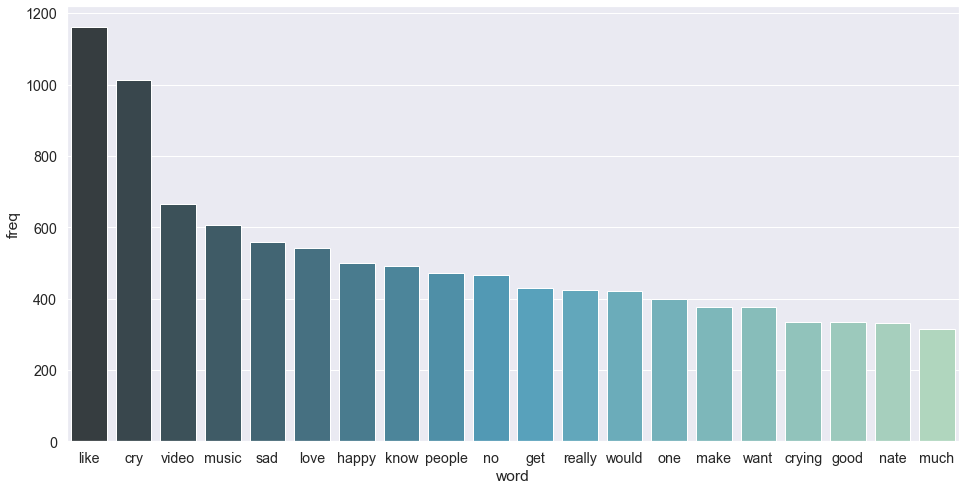

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=most_common_df, palette="GnBu_d", ax=ax)
plt.show();

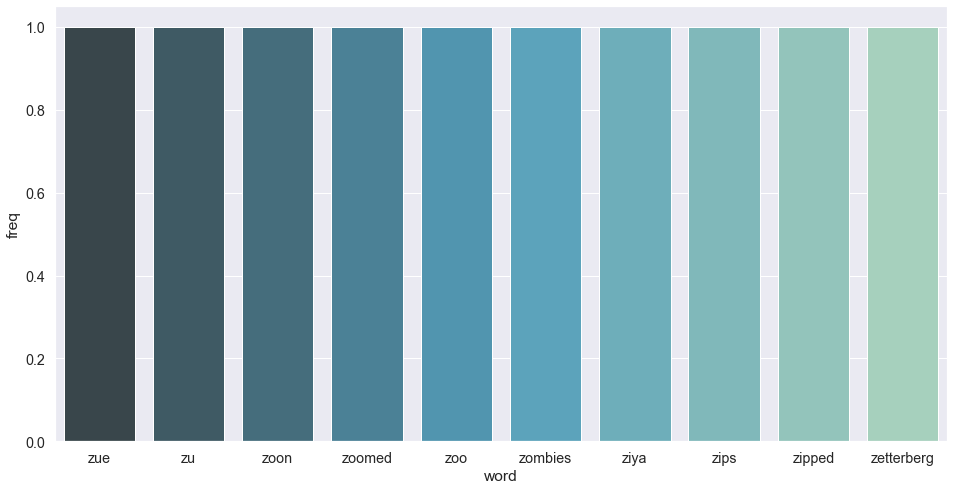

In [39]:
fig, ax = plt.subplots(figsize=(16, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=least_common_df, palette="GnBu_d", ax=ax)
plt.show();

In [17]:
preprocess_model = Pipeline(
    steps=[
        ('counting', Counting()),
        ('mkclean', MakeCleanText()),
        ('rmempty', FilterEmptyText())
    ]
)
X = preprocess_model.fit_transform(df)

## 2. Xây dựng model
Nhóm sử dụng hàm `train_test_split` để split tập training và testing theo tỉ lệ 8:2


Để đo được hiệu quả của một mô hình, nhóm sử dụng GridSearchCV để thực hiện việc cross-validation.

Nhóm sẽ kết hợp 3 hàm phân loại (`MultiNomialNb`, `LogisticRegression`, `SGDClassifier`) và 2 hàm vectorizer (`CountVectorizer`, `TF-IDF Vectorizer`)

Hàm grid_vect (tham khảo ở https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) sẽ nhận các tham số bao gồm `classifier`, `parameters_clf`,`vectorize`, `param_vectorize`, và in ra kết quả và tham số tối ưu trên tập `train` và `test`.

#### CountVectorize

Để phân loại từ, việc đầu tiên là phải ánh xạ các từ về số, hàm đầu tiên nhóm sẽ sử dụng là CountVectorizer. Hàm này sẽ gán cho mỗi từ 1 ID và số lần xuất hiện trong một câu.

#### TF-IDF Vectorizer

Vấn đề của CountVectorize là có thể có những từ xuất hiện khá nhiều, và không mang tính phân loại, nên cần phải loại bỏ, vì thế nhóm tìm hiểu đến hàm TF-IDF (term frequency - inverse document frequency) để giảm trọng số các từ này lại.



In [18]:
y = X['emotion']
X.drop(columns=['emotion'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

X_train.head()

,text,emotion,emotion_label,count_words,count_capital,count_excl_quest,count_positive_emojis,count_negative_emojis,clean_text
155,OH MY GOD PEOPLE,2,Angry,4,4,0,0,0,oh god people
1696,This is the music I use to be happy,3,Sad,9,0,0,0,0,music use happy
8819,*When dog in human shape*,0,Neutral,5,0,0,0,0,dog human shape
9802,Bro grace looked like she was on crack this wh...,0,Neutral,11,0,0,0,0,bro grace looked like crack whole video
1670,I felt sick today and now Im happy,0,Neutral,8,0,0,0,0,felt sick today happy


In [19]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [20]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None):
    
    textcountscols = [
        'count_negative_emojis',
        'count_positive_emojis',
        'count_excl_quest',
        'count_capital',
        'count_words'
    ]
    
    # Tạo pipeline chuyển 'clean_text' sang Count hay TFIDF
    cleanTextPipeline = Pipeline(
        steps=[
            ('cleantext', ColumnExtractor(cols='clean_text')), 
            ('vect', vect)
        ]
    )
    
    features = FeatureUnion(
        transformer_list=[
            ('textcounts', ColumnExtractor(cols=textcountscols)), 
            ('pipe', cleanTextPipeline)
        ],
        
        # Sử dụng tất cả CPUs
        n_jobs=-1
    )

    
    pipeline = Pipeline([
        ('features', features),
        ('clf', clf)
    ])
    
    # Kết hợp parameters_text (của BOW hay TTFIDF) và parameters_clf (hyper parameter của classifier)
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [21]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


parameters_logreg = {
    'clf__C': (0.5, 1.0),
}

parameters_sgd = {
    'clf__alpha': (1e-3, 1e-4),
    'clf__loss': ('hinge', 'log')
}

In [22]:
mnb = MultinomialNB()
logreg = LogisticRegression(max_iter=100, penalty='l2')
sgd = SGDClassifier(max_iter=100, penalty='l2')

countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()

In [23]:
# best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   34.6s finished


done in 35.588s

Best CV score: 0.611
Best parameters set:
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.616


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.59      0.56      0.58       681
           1       0.69      0.63      0.66       608
           2       0.56      0.54      0.55       499
           3       0.62      0.70      0.66       730

    accuracy                           0.62      2518
   macro avg       0.61      0.61      0.61      2518
weighted avg       0.62      0.62      0.61      2518



In [24]:
# best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


done in 84.770s

Best CV score: 0.641
Best parameters set:
	clf__C: 1.0
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.643


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.56      0.67      0.61       681
           1       0.70      0.67      0.69       608
           2       0.64      0.50      0.56       499
           3       0.69      0.69      0.69       730

    accuracy                           0.64      2518
   macro avg       0.65      0.63      0.64      2518
weighted avg       0.65      0.64      0.64      2518



In [25]:
# best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   58.8s finished


done in 61.382s

Best CV score: 0.628
Best parameters set:
	clf__alpha: 0.0001
	clf__loss: 'log'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.627


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       681
           1       0.73      0.61      0.66       608
           2       0.52      0.62      0.57       499
           3       0.72      0.64      0.68       730

    accuracy                           0.63      2518
   macro avg       0.63      0.63      0.63      2518
weighted avg       0.64      0.63      0.63      2518



In [26]:
# best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.2s finished


done in 27.705s

Best CV score: 0.598
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.610


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       681
           1       0.68      0.63      0.65       608
           2       0.59      0.47      0.52       499
           3       0.59      0.72      0.65       730

    accuracy                           0.61      2518
   macro avg       0.61      0.60      0.60      2518
weighted avg       0.61      0.61      0.61      2518



In [27]:
# best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.5, 1.0),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   52.3s finished
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\LAP11121-local\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


done in 53.839s

Best CV score: 0.637
Best parameters set:
	clf__C: 1.0
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.641


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       681
           1       0.70      0.66      0.68       608
           2       0.64      0.48      0.55       499
           3       0.68      0.69      0.69       730

    accuracy                           0.64      2518
   macro avg       0.65      0.63      0.63      2518
weighted avg       0.65      0.64      0.64      2518



In [28]:
# best_sgd_tfidf = grid_vect(sgd, parameters_sgd, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.001, 0.0001),
 'clf__loss': ('hinge', 'log'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.1min finished


done in 66.415s

Best CV score: 0.550
Best parameters set:
	clf__alpha: 0.001
	clf__loss: 'hinge'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.542


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.63      0.31      0.42       681
           1       0.46      0.80      0.58       608
           2       0.49      0.59      0.54       499
           3       0.72      0.51      0.60       730

    accuracy                           0.54      2518
   macro avg       0.57      0.55      0.53      2518
weighted avg       0.59      0.54      0.53      2518



## 3. Kết luận

Qua các lần chạy 6 model (mất khoảng 10 phút). Nhóm thu được kết quả sau cho best estimator:

| Classifier/Param | max_df | min_df | ngram_range | alpha  | C    | loss  | accuracy |
| :---------------:| :---:  | :----: | :---------: | :----: | :--: | :--:  | :------: |
| mnb_countvect    | 0.25   | 2      | (1,2)       | 0.5    | None | None  | 0.616    |
| mnb_tfidf        | 0.25   | 2      | (1,2)       | 0.25   | None | None  | 0.610    |
| logreg_countvect | 0.25   | 1      | (1,2)       | None   | 1.0  | None  | 0.643    |
| logreg_tfidf     | 0.25   | 2      | (1,2)       | None   | 1.0  | None  | 0.641    |
| sgd_countvect    | 0.5    | 1      | (1,2)       | 0.0001 | None | log   | 0.627    |
| sdg_tfidf        | 0.25   | 2      | (1,1)       | 0.001  | None | hinge | 0.542    |

Ta có thể thấy 2 model `logreg_countvect` và `logreg_tfidf` có performance cao nhất trong 6 model, nên nhóm quyết định chọn model `logreg_tfidf` để làm model chính để train toàn bộ tập dữ liệu.

## 4. Build Best full pipeline

In [41]:
vect = TfidfVectorizer(max_df=0.25, min_df=2, ngram_range=(1,2))
clf = logreg = LogisticRegression(max_iter=200, penalty='l2', C=1.0)

cleanTextPipeline = Pipeline(
    steps=[
        ('cleantext', ColumnExtractor(cols='clean_text')), 
        ('vect', vect)
    ]
)

textcountscols = [
    'count_negative_emojis',
    'count_positive_emojis',
    'count_excl_quest',
    'count_capital',
    'count_words'
]

features = FeatureUnion(
    transformer_list=[
        ('textcounts', ColumnExtractor(cols=textcountscols)), 
        ('pipe', cleanTextPipeline)
    ],
)

    
pipeline = Pipeline([
    ('features', features),
    ('clf', clf)
])

best_full_pipeline = Pipeline(
    steps=[
        ('counting', Counting()),
        ('mkclean', MakeCleanText()),
        ('rmempty', FilterEmptyText()),
        ('features', features),
        ('clf', clf)
    ]
)

In [36]:
model = best_full_pipeline.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [38]:
sentences = [
    'C\'mon guys, It is a happy music',
    'All the cats are so cute xD',
    'This video made me crying so much :((((',
    'I DON\'T GET IT',
    'It will be a good day today',
    'I hate him, he always make me angry',
    'I don\'t know why he yell at me :\'(',
    'He has no respect to me !!!!!',
]

X_predict = pd.DataFrame()
X_predict['text'] = sentences

predicted = model.predict(X_predict)
X_predict['predicted'] = np.array(list(map(mappingToEmotion, predicted)))
X_predict

,text,predicted
0,"C'mon guys, It is a happy music",Happy
1,All the cats are so cute xD,Happy
2,This video made me crying so much :((((,Sad
3,I DON'T GET IT,Angry
4,It will be a good day today,Happy
5,"I hate him, he always make me angry",Angry
6,I don't know why he yell at me :'(,Sad
7,He has no respect to me !!!!!,Angry
